# Import libraries

In [1]:
using Pkg

using Flux, MLDataPattern, Mill, JsonGrinder, JSON, Statistics, IterTools, StatsBase, ThreadTools
using JsonGrinder: suggestextractor, ExtractDict
using Mill: reflectinmodel
using CSV, DataFrames
using Random
using Dates
using Plots
using Printf

In [2]:
THREADS = Threads.nthreads() 

1

# Import data

In [3]:
PATH_BEN_REPORTS = "../data/dataset1/ben_preproc/"
PATH_MAL_REPORTS = "../data/dataset1/mal_preproc/"
PATH_TO_LABELS = "../data/dataset1/labels_preproc.csv";

In [4]:
df=CSV.read(PATH_TO_LABELS,DataFrame);

df_labels_ben=filter("label" => x -> x == 0,df)[1:100,:]
df_labels_mal=filter("label" => x -> x == 1,df)[1:100,:]

df_labels=vcat(df_labels_ben,df_labels_mal)

n_classes=length(Set(df_labels.label));

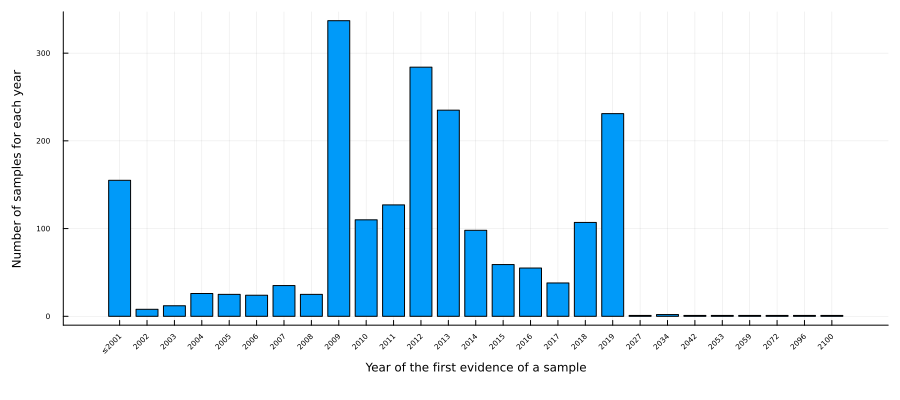

In [36]:
df_labels[!,:year] = map(i -> string(year(i)), df_labels.date) 
year_counts = sort(countmap(df_labels.year) |> collect, by = x -> x[1])
index = findfirst(j -> j[1] == "2001", year_counts)
previous_years = sum(map(j -> j[2], year_counts[1:index-1]))
year_counts[index] = Pair("≤"*year_counts[index][1], year_counts[index][2]+previous_years)
deleteat!(year_counts, 1:index-1)
bar(getindex.(year_counts,2), xticks=(1:length(year_counts), getindex.(year_counts,1)), xtickfontsize=5, ytickfontsize=5, xrotation=45, yguidefontsize=8, xguidefontsize=8, legend=false,
    xlabel="Year of the first evidence of a sample", ylabel="Number of samples for each year",size=(900,400),
    left_margin = 5Plots.mm, bottom_margin = 10Plots.mm)

In [23]:
@time begin
jsons = map(df_labels.name,df_labels.label) do n,y
    try 
        x=open(JSON.parse, "..\\data\\$(n).json")
        #delete!(x,"behavior") 
        delete!(x,"static")
        x=Dict("behavior" => Dict("apistats" => x["behavior"]["apistats"],
                                  "dll_loaded" => x["behavior"]["dll_loaded"],
                                  "regkey_read" => x["behavior"]["regkey_read"]))
    catch e
        @error "Error when processing sha $n: $e"
    end
end ;
end
n_samples=length(jsons)
println("N samples: $(n_samples)")
println("N labels: $(n_classes)")
@assert n_samples == length(df_labels.label)

  2.176907 seconds (1.79 M allocations: 132.600 MiB, 1.80% gc time, 6.17% compilation time)
N samples: 200
N labels: 2


In [24]:
jsons[1]["behavior"]

Dict{String, Vector{Any}} with 3 entries:
  "apistats"    => ["NtOpenSection", "NtOpenMutant", "RegCloseKey", "DrawTextEx…
  "dll_loaded"  => ["C:\\Windows\\system32\\VB6PT.DLL", "kernel32", "SXS.DLL", …
  "regkey_read" => []

# Split train and test, and define the schema 

In [25]:
# Time-based split
#=
timesplit = Date(2013,8,9)
train_indexes = findall(i -> df_labels.date[i] < timesplit, 1:n_samples)
test_indexes = [setdiff(Set(1:n_samples), Set(train_indexes))...] ;

train_size = length(train_indexes)
test_size = length(test_indexes)

println("Train size: $(train_size)")
println("Test size: $(test_size)") =#


# Random split 
idx=shuffle(collect(1:n_samples))
tr_frac=0.8
train_indexes=idx[1:round(Int,tr_frac*n_samples)]
test_indexes=setdiff(idx,train_indexes)

train_size = length(train_indexes)
test_size = length(test_indexes)

println("Train size: $(train_size)")
println("Test size: $(test_size)")  

Train size: 160
Test size: 40


In [26]:
chunks = Iterators.partition(train_indexes, div(train_size, THREADS))
sch_parts = tmap(chunks) do ch
    JsonGrinder.schema(jsons[ch])
end
complete_schema = merge(sch_parts...)
printtree(complete_schema)

[Dict] 	# updated = 160
  ╰── behavior: [Dict] 	# updated = 160
                  ├── regkey_read: [List] 	# updated = 160
                  │                  ╰── [Scalar - String], 584 unique values 	# updated = 1027
                  ├───── apistats: [List] 	# updated = 160
                  │                  ╰── [Scalar - String], 258 unique values 	# updated = 9045
                  ╰─── dll_loaded: [List] 	# updated = 160
                                     ╰── [Scalar - String], 443 unique values 	# updated = 3175


In [27]:
extractor=suggestextractor(complete_schema);
data=map(extractor,jsons);

In [31]:
jsons[1]["behavior"]["apistats"]

51-element Vector{Any}:
 "NtOpenSection"
 "NtOpenMutant"
 "RegCloseKey"
 "DrawTextExW"
 "GetSystemInfo"
 "RegQueryValueExA"
 "GetSystemWindowsDirectoryW"
 "NtQueryValueKey"
 "GetForegroundWindow"
 "GetFileAttributesW"
 "RegQueryValueExW"
 "NtMapViewOfSection"
 "GetSystemMetrics"
 ⋮
 "SearchPathW"
 "NtOpenKey"
 "SetWindowsHookExA"
 "LoadResource"
 "LdrGetProcedureAddress"
 "GetFileType"
 "SetEndOfFile"
 "LdrLoadDll"
 "NtCreateFile"
 "GetKeyState"
 "NtQueryInformationFile"
 "NtClose"

In [28]:
printtree(data[1])

ProductNode 	# 1 obs, 96 bytes
  ╰── behavior: ProductNode 	# 1 obs, 96 bytes
                  ├── regkey_read: BagNode 	# 1 obs, 104 bytes
                  │                  ╰── ArrayNode(2053×0 NGramMatrix with Int64 elements) 	# 0 obs, 104 bytes
                  ├───── apistats: BagNode 	# 1 obs, 80 bytes
                  │                  ╰── ArrayNode(259×51 OneHotArray with Bool elements) 	# 51 obs, 260 bytes
                  ╰─── dll_loaded: BagNode 	# 1 obs, 104 bytes
                                     ╰── ArrayNode(2053×15 NGramMatrix with Int64 elements) 	# 15 obs, 579 bytes


# Define the model

In [29]:
labelnames = sort(unique(df_labels.label))
neurons = 32
model = reflectinmodel(complete_schema, extractor,
	k -> Dense(k, neurons, relu),
	d -> SegmentedMeanMax(d),
	fsm = Dict("" => k -> Dense(k, n_classes)),
)
printtree(model)

ProductModel ↦ Dense(32 => 2) 	# 2 arrays, 66 params, 344 bytes
  ╰── behavior: ProductModel ↦ Dense(96 => 32, relu) 	# 2 arrays, 3_104 params, 12.203 KiB
                  ├── regkey_read: BagModel ↦ [SegmentedMean(32); SegmentedMax(32)] ↦ Dense(64 => 32, relu) 	# 4 arrays, 2_144 params, 8.531 KiB
                  │                  ╰── ArrayModel(Dense(2053 => 32, relu)) 	# 2 arrays, 65_728 params, 256.828 KiB
                  ├───── apistats: BagModel ↦ [SegmentedMean(32); SegmentedMax(32)] ↦ Dense(64 => 32, relu) 	# 4 arrays, 2_144 params, 8.531 KiB
                  │                  ╰── ArrayModel(Dense(259 => 32, relu)) 	# 2 arrays, 8_320 params, 32.578 KiB
                  ╰─── dll_loaded: BagModel ↦ [SegmentedMean(32); SegmentedMax(32)] ↦ Dense(64 => 32, relu) 	# 4 arrays, 2_144 params, 8.531 KiB
                                     ╰── ArrayModel(Dense(2053 => 32, relu)) 	# 2 arrays, 65_728 params, 256.828 KiB


In [51]:
minibatchsize = 100
function minibatch()
	idx = StatsBase.sample(train_indexes, minibatchsize, replace = false)
	reduce(catobs, data[idx]), Flux.onehotbatch(df_labels.label[idx], labelnames)
end

iterations = 200

function calculate_accuracy(x,y) 
    vals = tmap(x) do s
        Flux.onecold(softmax(model(s)), labelnames)[1]
    end
    mean(vals .== y)
end     
    

eval_trainset = shuffle(train_indexes)
eval_testset = shuffle(test_indexes)

cb = () -> begin
	train_acc = calculate_accuracy(data[eval_trainset], df_labels.label[eval_trainset])
	test_acc = calculate_accuracy(data[eval_testset], df_labels.label[eval_testset])
	println("accuracy: train = $train_acc, test = $test_acc")
end
ps = Flux.params(model)
loss = (x,y) -> Flux.logitcrossentropy(model(x), y)
opt = ADAM()

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [52]:
epochs=1
for i in 1:epochs
    println("Epoch $(i)")
    Flux.Optimise.train!(loss, ps, repeatedly(minibatch, iterations), opt, cb = Flux.throttle(cb, 2))
end

Epoch 1
accuracy: train = 0.695, test = 0.7075
accuracy: train = 0.935, test = 0.915
accuracy: train = 0.99, test = 0.94
accuracy: train = 1.0, test = 0.93
accuracy: train = 0.999375, test = 0.9525
accuracy: train = 1.0, test = 0.945


# Accuracy and ROC curve

In [53]:
full_train_accuracy = calculate_accuracy(data[train_indexes], df_labels.label[train_indexes])
full_test_accuracy = calculate_accuracy(data[test_indexes], df_labels.label[test_indexes])
println("Final evaluation:")
println("Accuratcy on train data: $(full_train_accuracy)")
println("Accuratcy on test data: $(full_test_accuracy)")

Final evaluation:
Accuratcy on train data: 1.0
Accuratcy on test data: 0.9475


AUC: 0.9885101010101011


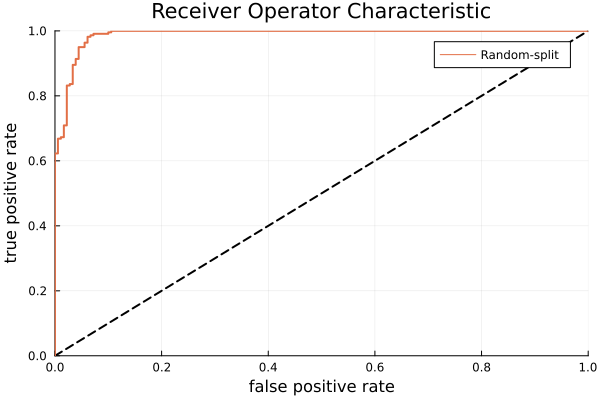

In [54]:
using ROC: roc,AUC

scores=softmax(model(data[test_indexes]))[2,:]
roc_curve = roc(scores, df_labels.label[test_indexes], true);

println("AUC: $(AUC(roc_curve))")
plot(roc_curve,lw=2,label="Random-split")
